Stimulating a neuron with synaptic current 

In [6]:
# Importing dependencies
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The dynamics of LIF neuron model under synaptic input can be explained by

<br>

\begin{equation}
    \tau_m\frac{dV(t)}{dt} = -(V(t)-E_L) - \frac{g_E(t)}{g_L} (V(t)-E_E) - \frac{g_I(t)}{g_L} (V(t)-E_I) + \frac{I_{\rm ext}}{g_L}
\end{equation}

<br>

where $I_{\rm ext}$ is an external current injected in the neuron

In [25]:
# Define the model parameters
def default_params(**kwargs):
    params = {}

    # Define neuron parameters
    params['tau_m'] = 50.0 # Membrane time constant
    params['g_L'] = 1e-6  # Leak resistance (in ohms)
    params['E_L'] = 0.0  # Resting potential (in mV)
    params['V_th'] = 20.0  # Threshold voltage (in mV)
    params['V_reset'] = 0.0  # Reset voltage (in mV)
    params['V_init'] = 0.0   # initial potential [mV]
    params['t_ref'] = 2.0  # Refractory period (in ms)

    # Define the simulation parameters
    params['dt'] = 0.1  # Time step (in ms)
    params['T'] = 1000.0  # Simulation duration (in ms)

    params['range_t'] = np.arange(0, params['T'], params['dt'])  # Vector of discretized time points [ms]

    # external parameters if any 
    for k in kwargs:
        params[k] = kwargs[k]

    return params

In [82]:
def generate_poisson_spikes(params, rate, user_seed=False):
    """
    Generate poisson spike trains

    Args:
    params      :   Parameters dictionary
    rate        :   Poisson noise amplitude (Hz)
    n           :   Number of Poisson spike trains
    user_seed   :   Random seed. int or boolean
    """
    # get simulation parameters
    dt, T = params['dt'], params['T'] 
    #range_t = params['range_t']
    #Lt = range_t.size
    n = int(T / dt) # Number of spike trains
    # set random seed
    if user_seed:
        np.random.seed(seed=user_seed)
    else:
        np.random.seed()
    
    # generate poisson spike trains in Hz
    I_pos = np.random.poisson(rate * (dt/1000.), size=n) 
    # convert spike trains to spike currents in mA
    I_pos = I_pos * 1e-3
    
    return I_pos

In [83]:
def synaptic_current(I0, tau_syn, t):
    return I0 * np.exp(-t/tau_syn)

In [85]:
def run_synaptic_LIF(params, I_ext):
    """
    Simulate the LIF dynamics with external input current

    Args:
        params     : parameter dictionary
        I_ext      : external input current [mA]. The injected current here can be a value or an array

    Returns:
        rec_v      : membrane potential
        rec_sp     : spike times
    """
 
    # Set parameters
    V_th, V_reset = params['V_th'], params['V_reset']
    tau_m, g_L = params['tau_m'], params['g_L']
    I0 = params['I0']
    tau_syn = params['tau_syn']
    V_init, E_L = params['V_init'], params['E_L']
    dt, range_t = params['dt'], params['range_t']
    t_ref = params['t_ref']
    Lt = range_t.size

    # Initialize voltage and current
    v = np.zeros(Lt)
    v[0] = V_init
    I_ext = I_ext * np.ones(Lt)
    tr = 0.  # the count for refractory duration

    rec_spikes = [] # record spike times
    # Simulate LIF dyanmics
    for it in range(Lt - 1):
        # Compute synaptic current
        if len(rec_spikes) > 0:
            I_syn = synaptic_current(I0, tau_syn, t)
        else:
            I_syn = 0
        
        # Compute total input current
        I_total = I_ext[it] + I_syn

        if tr > 0:  # check if in refractory period
            v[it] = V_reset  # set voltage to reset
            tr = tr - 1 # reduce running counter of refractory period

        elif v[it] >= V_th:  # if voltage over threshold
            rec_spikes = np.append(rec_spikes, it*dt)  # record spike event
            v[it] = V_reset  # reset voltage
            tr = t_ref / dt  # set refractory time

        # calculate the increment of the membrane potential
        dv = (-(v[it] - E_L) + I_total / g_L) * (dt / tau_m)

        # Update the membrane potential
        v[it + 1] = v[it] + dv
        
        # Get spike times in ms
        rec_spikes = np.array(rec_spikes) * dt
        # compute firing rate
        num_spikes = len(rec_spikes)
        duration = Lt * dt
        firing_rate = num_spikes / duration * 1000 

    return firing_rate

In [42]:
def plot_firing_rate_vs_input(params, I_values, pre_spike_train_ex, pre_spike_train_i):
    """
    Plots the firing rate as a function of the input current.

    Args:
    params     : parameter dictionary
    rate       : average firing rate of the Poisson process
    mu_range   : range of input current values to test
    num_trials : number of trials to run for each input current value

    Returns:
    None (plots the results)
    """
    firing_rates = []
    for I in I_values:
        firing_rate = run_synaptic_LIF(params, I, pre_spike_train_ex, pre_spike_train_i)
        firing_rates.append(firing_rate)

    plt.plot(I_values, firing_rates, 'b')
    plt.xlabel('Input Current (mA)')
    plt.ylabel('Firing Rate (Hz)')
    plt.title('Firing Rate vs. Input Current')
    plt.savefig('Firing_rate(Hz)_vs_External_input_current(mA)_plot.pdf')
    plt.show()

In [84]:
# Default parameters
params = default_params(T=1000.)

In [77]:
# Add parameters
params['tau_syn'] = 5.  # [ms]
params['I0'] = 20

# Generate presynaptic spike trains
pre_spike_train_ex = generate_poisson_spikes(params, rate=300)
pre_spike_train_in = generate_poisson_spikes(params, rate=100)

rate = 100 # poisson rate (Hz)
I_pos = generate_poisson_spikes(params, rate=rate, user_seed=False)

In [78]:
# Simulate conductance-based LIF model
firing_rate = run_synaptic_LIF(params, I_ext=I_pos, pre_spike_train_ex=pre_spike_train_ex,
                                     pre_spike_train_in=pre_spike_train_in)

Text(0, 0.5, '$I_{pos}$ (mA)')

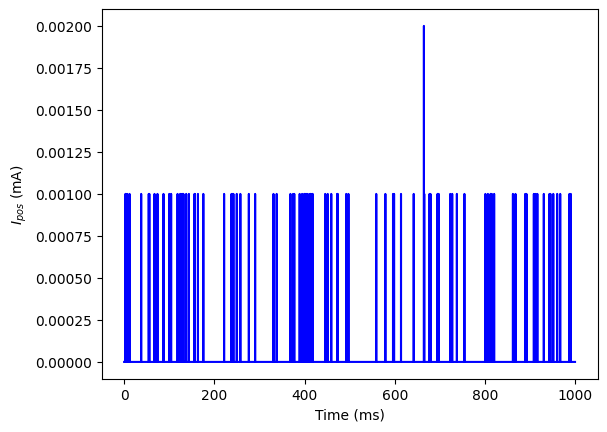

In [80]:
# Plot input spikes
plt.plot(params['range_t'], I_pos, 'b')
plt.xlabel('Time (ms)')
plt.ylabel(r'$I_{pos}$ (mA)')

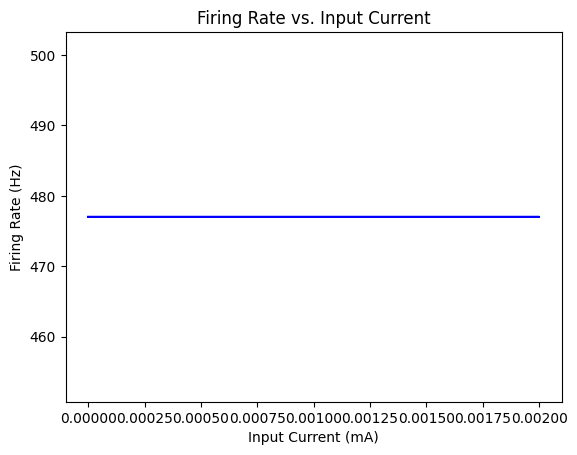

In [81]:
# Plot firing rate vs input current
plot_firing_rate_vs_input(params, I_pos, pre_spike_train_ex, pre_spike_train_in)